<a href="https://colab.research.google.com/github/ChrizZhuang/memtransistor_NLP/blob/main/text_sentiment_classification_rnn_pure_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2IXX0M/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2IXX0M/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2IXX0M/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
#print(type(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print(type(example)) # type of example: <class 'tensorflow.python.framework.ops.EagerTensor'>
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"The first one was the best. The second one sucked because the dialog was terrible. Although, the storyline wasn't so bad (in fact, all story lines are good and bad). Throughout the movie, I dosed off a few times. I know that Jackie Chan is a great martial arts expertise, but not a good actor in Rush Hour 2. Chris Tucker, too, wasn't good. And Zhang Ziyi, what can I say, a few lines, terrible acting (But that's based on her script). All the characters there were not that good. But, some of the things I like in Rush Hour 2 is always the action and less sex scenes. I know that Jackie Chan doesn't do those things which is good for him."
 b'This movie explores the difficulties that strain hopes, dreams, love and friendship, and incorporates humour beautifully. Along with a stunning cast and brilliant filming, the sound track enhances and amplifies the atmosphere and mood of this work of art. All actors and actresses give an extremely good performance, surpassing expectation in ev

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [11]:
VOCAB_SIZE = 1000
# Maximum size of the vocabulary for this layer. 
# This should only be specified when adapting a vocabulary or when setting pad_to_max_tokens=True. 
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
# adapt: Fits the state of the preprocessing layer to the data being passed.
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [13]:
vocab = np.array(encoder.get_vocabulary())
print(len(vocab)) # len(vocab) = 1000 as VOCAB_SIZE = 1000
vocab[:20]

1000


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [18]:
encoded_example = encoder(example)[:3].numpy()
for i in range(3):
  print(len(encoded_example[i]))

995
995
995


With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [19]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The first one was the best. The second one sucked because the dialog was terrible. Although, the storyline wasn't so bad (in fact, all story lines are good and bad). Throughout the movie, I dosed off a few times. I know that Jackie Chan is a great martial arts expertise, but not a good actor in Rush Hour 2. Chris Tucker, too, wasn't good. And Zhang Ziyi, what can I say, a few lines, terrible acting (But that's based on her script). All the characters there were not that good. But, some of the things I like in Rush Hour 2 is always the action and less sex scenes. I know that Jackie Chan doesn't do those things which is good for him."
Round-trip:  the first one was the best the second one [UNK] because the dialog was terrible although the storyline wasnt so bad in fact all story lines are good and bad throughout the movie i [UNK] off a few times i know that [UNK] [UNK] is a great [UNK] [UNK] [UNK] but not a good actor in [UNK] hour 2 [UNK] [UNK] too wasnt good and [UNK] [UNK

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [23]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00625656]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [26]:
# predict on a sample text with padding

padding = "the " * 2000
# print(np.array([sample_text, padding]))
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00625655]


Compile the Keras model to configure the training process:

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [28]:
history = model.fit(train_dataset, epochs=5,
                   validation_data=test_dataset,
                   validation_steps=10)

Epoch 1/5
391/391 [==============================] - 68s 158ms/step - loss: 0.6417 - accuracy: 0.5796 - val_loss: 0.5393 - val_accuracy: 0.6844
Epoch 2/5
391/391 [==============================] - 59s 149ms/step - loss: 0.4233 - accuracy: 0.8092 - val_loss: 0.4099 - val_accuracy: 0.8047
Epoch 3/5
391/391 [==============================] - 59s 148ms/step - loss: 0.3501 - accuracy: 0.8494 - val_loss: 0.3793 - val_accuracy: 0.8266
Epoch 4/5
391/391 [==============================] - 62s 156ms/step - loss: 0.3313 - accuracy: 0.8606 - val_loss: 0.3724 - val_accuracy: 0.8234
Epoch 5/5
391/391 [==============================] - 60s 151ms/step - loss: 0.3174 - accuracy: 0.8672 - val_loss: 0.3666 - val_accuracy: 0.8281


In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 27s 68ms/step - loss: 0.3257 - accuracy: 0.8573
Test Loss: 0.3257460594177246
Test Accuracy: 0.8572800159454346


(0.0, 0.6579272165894509)

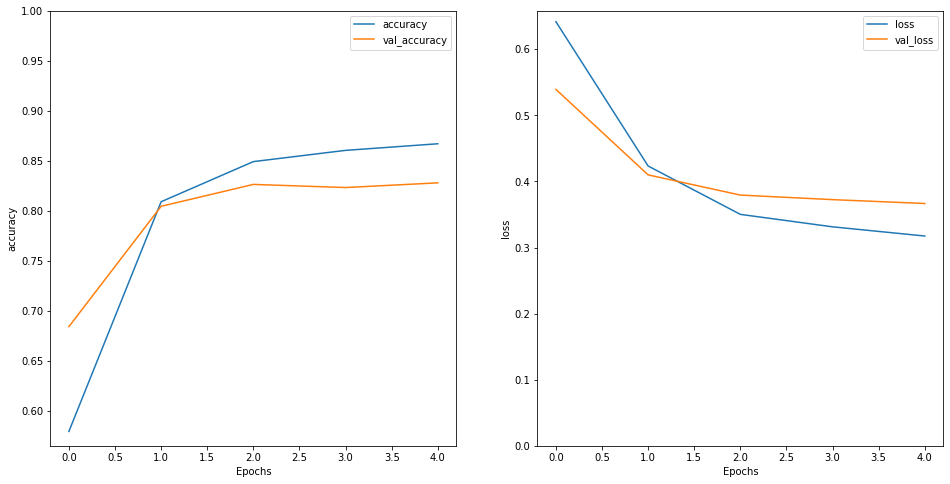

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [31]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))